# Analyzing Tumor Mutational Burden in .maf files

Tumor mutational burden is the total number of mutations (changes) found in the DNA of cancer cells. Knowing the tumor mutational burden may help plan the best treatment. For example, tumors that have a high number of mutations appear to be more likely to respond to certain types of immunotherapy. Tumor mutational burden is being used as a type of biomarker. Also called TMB. (NIH National Cancer Institute)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dcr = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/wxs_filter_onlytsb_2.maf", sep = "\t")
dcr_tenremoved = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/wxs_filter_tenremoved_tsb.maf", sep = "\t")

In [3]:
dcr_tenremoved_mutcounts = dcr_tenremoved.groupby("Tumor_Sample_Barcode").size()
dcr_tenremoved_tmb = dcr_tenremoved_mutcounts / 30

In [4]:
dcr_tenremoved_tmb

,0
Tumor_Sample_Barcode,
DCR0003_TA,211.533333
DCR0011_TA,6.866667
DCR0027_TA,387.933333
DCR002_TA,22.633333
DCR0045_TA,48.033333
DCR0056_TA,131.900000
DCR090_TA,101.233333
DCR102_TA,13.766667
DCR103_TA,0.700000


Maybe I need to filter more of the introns and stuff out. One article said

In [5]:
dcr_mutcounts = dcr.groupby("Tumor_Sample_Barcode").size() # series of mutation counts for each sample
dcr_tmb = dcr_mutcounts / 30

In [6]:
dcr_tmb

,0
Tumor_Sample_Barcode,
DCR0003_TA,1770.533333
DCR0011_TA,570.600000
DCR0027_TA,2670.500000
DCR002_TA,256.033333
DCR0045_TA,617.566667
DCR0056_TA,1209.366667
DCR090_TA,861.833333
DCR102_TA,114.866667
DCR103_TA,6.033333


<BarContainer object of 10 artists>

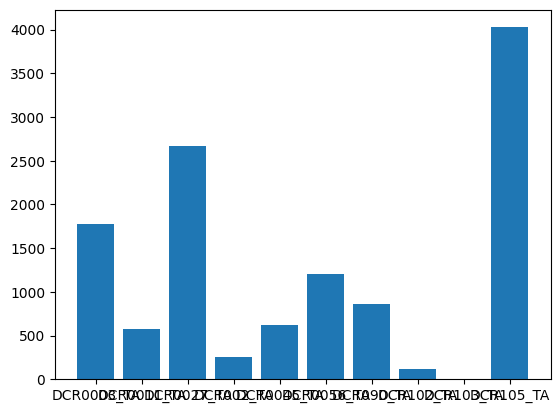

In [7]:
# graph the Native Hawaiian CRC tmb
plt.bar(x=dcr_tmb.index, height=dcr_tmb)

In [8]:
coad_tcga = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/tcga_maf/coad_tcga.maf", sep="\t")

In [9]:
coad_tcga.groupby("Variant_Classification").size()

,0
Variant_Classification,
Frame_Shift_Del,13784
Frame_Shift_Ins,3657
In_Frame_Del,1243
In_Frame_Ins,88
Missense_Mutation,137248
Nonsense_Mutation,10417
Nonstop_Mutation,113
Splice_Site,3160
Translation_Start_Site,168


### Importing TCGA maf data

In [10]:
# import tcga data
coad_tcga = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/tcga_maf/coad_tcga.maf", sep="\t")
coad_clinical = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/tcga_maf/clinical_coad_tcga.csv")
# white_tcga = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/tcga_maf/white_tcga.maf", sep="\t")
# black_tcga = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/tcga_maf/black_tcga.maf", sep="\t")
# asian_tcga = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/tcga_maf/asian_tcga.maf", sep="\t")

Split the coad_tcga dataframe of mutations into

In [11]:
grouped = coad_clinical.groupby("CDR_race")["Tumor_Sample_Barcode"].agg(list)

# Initialize an empty dictionary to store subsets
subsetted_dfs = {}

# Iterate over each group
for group, barcodes in grouped.items():
    # Subset df_subset based on the list of barcodes
    subsetted_dfs[group] = coad_tcga[coad_tcga['Tumor_Sample_Barcode'].isin(barcodes)]

In [12]:
white_tcga = subsetted_dfs['WHITE']
asian_tcga = subsetted_dfs['ASIAN']
black_tcga = subsetted_dfs['BLACK OR AFRICAN AMERICAN']

In [13]:
# save subsetted dataframes again
# white_tcga.to_csv("/content/drive/MyDrive/white_tcga.maf", sep="\t", index=False)
# asian_tcga.to_csv("asian_tcga.maf", sep="\t", index=False)
# black_tcga.to_csv("black_tcga.maf", sep="\t", index=False)

In [14]:
white_tmb = white_tcga.groupby("Tumor_Sample_Barcode").size() / 30
black_tmb = black_tcga.groupby("Tumor_Sample_Barcode").size() / 30
asian_tmb = asian_tcga.groupby("Tumor_Sample_Barcode").size() / 30
coad_tmb = coad_tcga.groupby("Tumor_Sample_Barcode").size() / 30

In [15]:
dcr_tenremoved_tmb.mean()

142.96333333333334

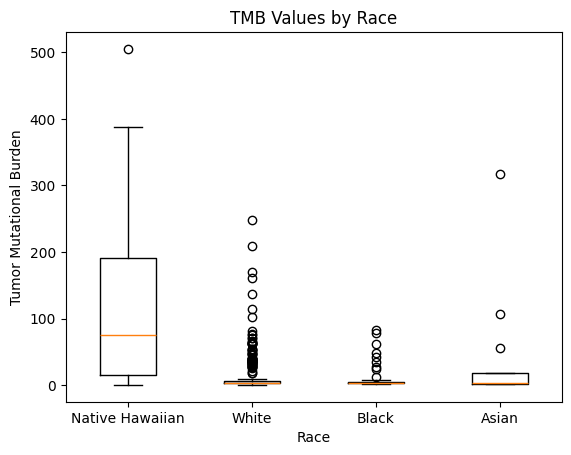

In [22]:
labels = ['Native Hawaiian', 'White', 'Black', 'Asian']
plt.boxplot([dcr_tenremoved_tmb, white_tmb, black_tmb, asian_tmb], labels = labels)
plt.xlabel("Race")
plt.ylabel("Tumor Mutational Burden")
_ = plt.title("TMB Values by Race")

## Statistical Analysis Attempt of Race Comparisons

In [18]:
# Kruskal-Wallis Test

from scipy.stats import kruskal

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(dcr_tenremoved_tmb, white_tmb, black_tmb, asian_tmb)

# Print the results
print("Kruskal-Wallis Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Determine significance
if p_value < 0.05:
    print("The differences in TMB between racial groups are statistically significant.")
else:
    print("There is no significant difference in TMB between racial groups.")


Kruskal-Wallis Test:
Statistic: 13.879858851016232
P-value: 0.0030733312887692376
The differences in TMB between racial groups are statistically significant.


Welch's t-test: This is an adaptation of the t-test that does not assume equal variances between groups. It's more robust when sample sizes and variances are unequal.

In [19]:
# Welch's t-test for pairwise comparisons

from scipy.stats import ttest_ind

# Example data (replace with your TMB values)
tmb_groups = [dcr_tenremoved_tmb, white_tmb, black_tmb, asian_tmb]

# Perform pairwise comparisons using Welch's t-test
welch_p_values = []
for i in range(len(tmb_groups)):
    for j in range(i+1, len(tmb_groups)):
        group1 = tmb_groups[i]
        group2 = tmb_groups[j]
        t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
        print(f"Comparison between group {i+1} and group {j+1}: p-value = {p_value}")
        welch_p_values.append(p_value)

Comparison between group 1 and group 2: p-value = 0.044513507920267564
Comparison between group 1 and group 3: p-value = 0.04064804612901149
Comparison between group 1 and group 4: p-value = 0.1255477785651348
Comparison between group 2 and group 3: p-value = 0.2839112969709942
Comparison between group 2 and group 4: p-value = 0.3053307769159175
Comparison between group 3 and group 4: p-value = 0.25947400047024394


Mann-Whitney U test (Wilcoxon rank-sum test): This is a non-parametric test that does not require the data to be normally distributed. It compares the ranks of values between two groups and is suitable for unequal sample sizes.

In [20]:
from scipy.stats import mannwhitneyu

# Perform pairwise comparisons using Mann-Whitney U test
mann_p_values = []
for i in range(len(tmb_groups)):
    for j in range(i+1, len(tmb_groups)):
        group1 = tmb_groups[i]
        group2 = tmb_groups[j]
        stat, p_value = mannwhitneyu(group1, group2)
        print(f"Comparison between group {i+1} and group {j+1}: p-value = {p_value}")
        mann_p_values.append(p_value)

Comparison between group 1 and group 2: p-value = 0.00029841853698174114
Comparison between group 1 and group 3: p-value = 0.0005034713386463471
Comparison between group 1 and group 4: p-value = 0.03774297659258332
Comparison between group 2 and group 3: p-value = 0.39844697265230467
Comparison between group 2 and group 4: p-value = 0.8375555394780826
Comparison between group 3 and group 4: p-value = 0.5146342142691369


In [21]:
# generate dataframes for illustrating significance:

import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

df = {
    "Group 1": ["Native Hawaiian", "Native Hawaiian", "Native Hawaiian", "White", "White", "Black"],
    "Group 2": ["White", "Black", "Asian", "Black", "Asian", "Asian"],
    "Welch's t-test": welch_p_values,
    "MWU": mann_p_values
}

tmb_table = pd.DataFrame(df)
tmb_table

,Group 1,Group 2,Welch's t-test,MWU
0,Native Hawaiian,White,0.044514,0.000298
1,Native Hawaiian,Black,0.040648,0.000503
2,Native Hawaiian,Asian,0.125548,0.037743
3,White,Black,0.283911,0.398447
4,White,Asian,0.305331,0.837556
5,Black,Asian,0.259474,0.514634
